In [1]:
 # Dependencies
import csv
import matplotlib.pyplot as plt
import requests
import pandas as pd
import geopandas as gpd
from sodapy import Socrata
import json
from datetime import date
import datetime
import numpy as np
from census import Census
from us import states

from config import api_key
c = Census(api_key, year=2013)


## I. Extract and manipulate data CHIP enrollment data

### I.1 Request data using API monthly CHIP enrollment data per state (6/2017 - 5/2019)

In [2]:
## Data query setup
basic_url = "https://data.medicaid.gov/resource/74p5-kixw.json?"

response = requests.get(basic_url).json()
print (len(response))
print(json.dumps(response[0], indent=2, sort_keys=True))

1000
{
  ":@computed_region_7gxu_g3ub": "8915",
  "applications_for_financial_assistance_submitted_to_the_state_based_marketplace": "N/A",
  "final_report": "N",
  "geocoded_column": {
    "coordinates": [
      -93.9196,
      45.7326
    ],
    "type": "Point"
  },
  "individuals_determined_eligible_for_medicaid_at_application": "8347",
  "individuals_determined_eligible_for_medicaid_at_application_footnotes": "Includes CHIP; Count is of Households, Not Individuals",
  "latitude": "45.7326",
  "longitude": "-93.9196",
  "medicaid_and_chip_child_enrollment": "569605",
  "new_applications_submitted_to_medicaid_and_chip_agencies": "18967",
  "preliminary_updated": "P",
  "report_date": "2018-11-01T00:00:00.000",
  "state_abbreviation": "MO",
  "state_expanded_medicaid": "N",
  "state_name": "Missouri",
  "total_applications_for_financial_assistance_submitted_at_state_level": "18967",
  "total_chip_enrollment": "31139",
  "total_medicaid_and_chip_enrollment": "895063",
  "total_medicaid_

In [3]:
# Create dictionary of states
with open('states.csv', mode='r', encoding='utf-8-sig') as infile:
    reader = csv.reader(infile)
    states = {rows[0]:rows[1] for rows in reader}

states_list = [ k for k in states ]
states_list

['AK',
 'AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [4]:
# Create list of dates for making the query
dates_list= ['2017-06', '2017-07', '2017-08', '2017-09', '2017-10',
'2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
'2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
'2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
'2019-02', '2019-03', '2019-04', '2019-05']

In [5]:
# Create a dataframe for monthly observations per state 
# for each of the months in the dates list

df = pd.DataFrame(dates_list, columns=['date'])

df['state']=""
df=df.set_index('date')
df.index

df1 = pd.DataFrame(dates_list, columns=['date'])
df1['state']=""
df1=df1.set_index('date')
df1

for i in range(len(states_list)):
    df1['state']=states_list[i]
    df=pd.concat([df, df1])
df.describe
pd.set_option('display.max_rows', None)
df = df.loc[df["state"] != ""]

df.index
df=df.reset_index()
df.head()

,date,state
0,2017-06,AK
1,2017-07,AK
2,2017-08,AK
3,2017-09,AK
4,2017-10,AK


In [6]:
# Add empty columns for adding the following data to the dataframe: 
# coordinates, state name, state abbreviation and month

df['lat']=""
df['lon']=""
df['chip']=""
df['state_name']=""
df['state_abbrev']=""
df['month']=""

df=df.set_index(['date','state'])
df.head()

,,lat,lon,chip,state_name,state_abbrev,month
date,state,,,,,,
2017-06,AK,,,,,,
2017-07,AK,,,,,,
2017-08,AK,,,,,,
2017-09,AK,,,,,,
2017-10,AK,,,,,,


In [7]:
# Make the API request and populate dataframe's empty fields

for index, row in df.iterrows():
    try:
        s = index
        response = requests.get(basic_url+'state_abbreviation='+s[1]+'&report_date='+s[0]+'-01T00:00:00.000').json()
        print(response[0]["state_name"]) # print state name just to see where the loop is
        df.loc[(index[0],index[1]),"month"]=s[0]
        df.loc[(index[0],index[1]),"state_abbrev"]=response[0]["state_abbreviation"]
        df.loc[(index[0],index[1]),"chip"]=response[0]["total_chip_enrollment"]
        df.loc[(index[0],index[1]),"state_name"]=response[0]["state_name"]
        df.loc[(index[0],index[1]),"lat"]=response[0]["latitude"]
        df.loc[(index[0],index[1]),"lon"]=response[0]["longitude"]
    except IndexError as e:
#         df.loc[(index[0],index[1]),"month"]="NaN"
        df.loc[(index[0],index[1]),"state_abbrev"]="NaN"
        df.loc[(index[0],index[1]),"chip"]="NaN"
        df.loc[(index[0],index[1]),"state_name"]="NaN"
        df.loc[(index[0],index[1]),"lat"]="NaN"
        df.loc[(index[0],index[1]),"lon"]="NaN"
        print ('IndexError - "%s"' % str(e) )
    except ValueError as e:
#         df.loc[(index[0],index[1]),"month"]="NaN"
        df.loc[(index[0],index[1]),"state_abbrev"]="NaN"
        df.loc[(index[0],index[1]),"chip"]="NaN"
        df.loc[(index[0],index[1]),"state_name"]="NaN"
        df.loc[(index[0],index[1]),"lat"]="NaN"
        df.loc[(index[0],index[1]),"lon"]="NaN"
        print ('IndexError - "%s"' % str(e) )

Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Alabama
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arkansas
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
Arizona
California
California
California
California
California
California
California
California
California
California
California
California
California
California
California
California
California
California
California
California
California
C

Ohio
Ohio
Ohio
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oklahoma
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Oregon
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Pennsylvania
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rhode Island
Rho

### I.2 Manipulate CHIP enrollment dataframe

In [8]:
# Modify data types
df=df.reset_index()
df['state_name'] = df['state_name'].astype('str')
df['state_abbrev']=df.state_abbrev.astype(str)
df['date'] = df['date'].astype('datetime64')
df['chip']=df.chip.astype(float)
df['lat']=df.lat.astype(float)
df['lon']=df.lon.astype(float)
df.info() 
# df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 8 columns):
date            1224 non-null datetime64[ns]
state           1224 non-null object
lat             1224 non-null float64
lon             1224 non-null float64
chip            1224 non-null float64
state_name      1224 non-null object
state_abbrev    1224 non-null object
month           1224 non-null object
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 76.6+ KB


In [17]:
# Reset index and set state_name as index
df = df.reset_index()
df=df[['state_name', 'date', 'state', 'lat','lon','chip', 'state_abbrev','month']]
df.head()

,state_name,date,state,lat,lon,chip,state_abbrev,month
0,Alaska,2017-06-01,AK,61.385,-152.2683,12454.0,AK,2017-06
1,Alaska,2017-07-01,AK,61.385,-152.2683,12605.0,AK,2017-07
2,Alaska,2017-08-01,AK,61.385,-152.2683,12763.0,AK,2017-08
3,Alaska,2017-09-01,AK,61.385,-152.2683,12602.0,AK,2017-09
4,Alaska,2017-10-01,AK,61.385,-152.2683,12963.0,AK,2017-10


In [18]:
# Add a colummn to df with the CHIP enrollment initial value (2017-06) per state
chip_initial=df[['month', 'state_name', 'chip']]
chip_initial =chip_initial.loc[chip_initial["month"] == "2017-06",:]
chip_initial.head()

chip_change = pd.merge(df, chip_initial, on="state_name")
chip_change.head()

,state_name,date,state,lat,lon,chip_x,state_abbrev,month_x,month_y,chip_y
0,Alaska,2017-06-01,AK,61.385,-152.2683,12454.0,AK,2017-06,2017-06,12454.0
1,Alaska,2017-07-01,AK,61.385,-152.2683,12605.0,AK,2017-07,2017-06,12454.0
2,Alaska,2017-08-01,AK,61.385,-152.2683,12763.0,AK,2017-08,2017-06,12454.0
3,Alaska,2017-09-01,AK,61.385,-152.2683,12602.0,AK,2017-09,2017-06,12454.0
4,Alaska,2017-10-01,AK,61.385,-152.2683,12963.0,AK,2017-10,2017-06,12454.0


In [19]:
# Calculate the % change in enrollment by month 
# where the comparison month is always 6/2017 

# df = df.set_index(['state_name'])
chip_change['chip_change'] = (chip_change['chip_x']/chip_change['chip_y'])-1


In [20]:
chip_change.head()

,state_name,date,state,lat,lon,chip_x,state_abbrev,month_x,month_y,chip_y,chip_change
0,Alaska,2017-06-01,AK,61.385,-152.2683,12454.0,AK,2017-06,2017-06,12454.0,0.000000
1,Alaska,2017-07-01,AK,61.385,-152.2683,12605.0,AK,2017-07,2017-06,12454.0,0.012125
2,Alaska,2017-08-01,AK,61.385,-152.2683,12763.0,AK,2017-08,2017-06,12454.0,0.024811
3,Alaska,2017-09-01,AK,61.385,-152.2683,12602.0,AK,2017-09,2017-06,12454.0,0.011884
4,Alaska,2017-10-01,AK,61.385,-152.2683,12963.0,AK,2017-10,2017-06,12454.0,0.040870


In [21]:
# Keep only relevant columns
chip_change=chip_change[['state_name', 'date', 'lat','lon', 'state_abbrev','month_x','chip_x', 'chip_change']]
# chip_change['chip_change'] = pd.Series(["{0:.2f}%".format(val * 100) for val in chip_change['chip_change']])
chip_change.info()
chip_change.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224 entries, 0 to 1223
Data columns (total 8 columns):
state_name      1224 non-null object
date            1224 non-null datetime64[ns]
lat             1224 non-null float64
lon             1224 non-null float64
state_abbrev    1224 non-null object
month_x         1224 non-null object
chip_x          1224 non-null float64
chip_change     1224 non-null float64
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 86.1+ KB


,state_name,date,lat,lon,state_abbrev,month_x,chip_x,chip_change
0,Alaska,2017-06-01,61.385,-152.2683,AK,2017-06,12454.0,0.000000
1,Alaska,2017-07-01,61.385,-152.2683,AK,2017-07,12605.0,0.012125
2,Alaska,2017-08-01,61.385,-152.2683,AK,2017-08,12763.0,0.024811
3,Alaska,2017-09-01,61.385,-152.2683,AK,2017-09,12602.0,0.011884
4,Alaska,2017-10-01,61.385,-152.2683,AK,2017-10,12963.0,0.040870


In [22]:
# Rename columns
chip_change=chip_change.rename(columns={'state_name':'state',
                          'chip_x':'chip_enrollment',
                          'month_x':'month'}) 


In [23]:
chip_change.to_csv('chip_change.csv')
chip_change.head(35)

,state,date,lat,lon,state_abbrev,month,chip_enrollment,chip_change
0,Alaska,2017-06-01,61.385,-152.2683,AK,2017-06,12454.0,0.000000
1,Alaska,2017-07-01,61.385,-152.2683,AK,2017-07,12605.0,0.012125
2,Alaska,2017-08-01,61.385,-152.2683,AK,2017-08,12763.0,0.024811
3,Alaska,2017-09-01,61.385,-152.2683,AK,2017-09,12602.0,0.011884
4,Alaska,2017-10-01,61.385,-152.2683,AK,2017-10,12963.0,0.040870
5,Alaska,2017-11-01,61.385,-152.2683,AK,2017-11,12802.0,0.027943
6,Alaska,2017-12-01,61.385,-152.2683,AK,2017-12,12919.0,0.037337
7,Alaska,2018-01-01,61.385,-152.2683,AK,2018-01,13141.0,0.055163
8,Alaska,2018-02-01,61.385,-152.2683,AK,2018-02,13163.0,0.056930
9,Alaska,2018-03-01,61.385,-152.2683,AK,2018-03,13280.0,0.066324


## II. Extract and manipulate Census data

### II.1 Extract data from Census API

In [25]:
#c.acs5.get(('NAME', 'B25034_010E'),#.acs.get() es el metodo que viene en la documentacion
          #{'for': 'state:{}'.format(states.MD.fips)})

In [26]:
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E"), {'for': 'state:*'})
census_data

[{'NAME': 'Alabama',
  'B19013_001E': 43253.0,
  'B01003_001E': 4799277.0,
  'B01002_001E': 38.1,
  'B19301_001E': 23680.0,
  'B17001_002E': 870631.0,
  'state': '01'},
 {'NAME': 'Alaska',
  'B19013_001E': 70760.0,
  'B01003_001E': 720316.0,
  'B01002_001E': 33.6,
  'B19301_001E': 32651.0,
  'B17001_002E': 69514.0,
  'state': '02'},
 {'NAME': 'Arizona',
  'B19013_001E': 49774.0,
  'B01003_001E': 6479703.0,
  'B01002_001E': 36.3,
  'B19301_001E': 25358.0,
  'B17001_002E': 1131901.0,
  'state': '04'},
 {'NAME': 'Arkansas',
  'B19013_001E': 40768.0,
  'B01003_001E': 2933369.0,
  'B01002_001E': 37.5,
  'B19301_001E': 22170.0,
  'B17001_002E': 547328.0,
  'state': '05'},
 {'NAME': 'California',
  'B19013_001E': 61094.0,
  'B01003_001E': 37659181.0,
  'B01002_001E': 35.4,
  'B19301_001E': 29527.0,
  'B17001_002E': 5885417.0,
  'state': '06'},
 {'NAME': 'Colorado',
  'B19013_001E': 58433.0,
  'B01003_001E': 5119329.0,
  'B01002_001E': 36.1,
  'B19301_001E': 31109.0,
  'B17001_002E': 660874.0,

In [27]:
census_pd = pd.DataFrame(census_data)
census_pd.head()

,B01002_001E,B01003_001E,B17001_002E,B19013_001E,B19301_001E,NAME,state
0,38.1,4799277.0,870631.0,43253.0,23680.0,Alabama,01
1,33.6,720316.0,69514.0,70760.0,32651.0,Alaska,02
2,36.3,6479703.0,1131901.0,49774.0,25358.0,Arizona,04
3,37.5,2933369.0,547328.0,40768.0,22170.0,Arkansas,05
4,35.4,37659181.0,5885417.0,61094.0,29527.0,California,06


### II.2. Manipulate data retrieved from Census

In [28]:
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "NAME": "Name",})
census_pd.head()

,Median Age,Population,Poverty Count,Household Income,Per Capita Income,Name,state
0,38.1,4799277.0,870631.0,43253.0,23680.0,Alabama,01
1,33.6,720316.0,69514.0,70760.0,32651.0,Alaska,02
2,36.3,6479703.0,1131901.0,49774.0,25358.0,Arizona,04
3,37.5,2933369.0,547328.0,40768.0,22170.0,Arkansas,05
4,35.4,37659181.0,5885417.0,61094.0,29527.0,California,06


In [29]:
census_pd["Poverty Rate"] = 100 * census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)
census_pd.head()

,Median Age,Population,Poverty Count,Household Income,Per Capita Income,Name,state,Poverty Rate
0,38.1,4799277.0,870631.0,43253.0,23680.0,Alabama,01,18.140878
1,33.6,720316.0,69514.0,70760.0,32651.0,Alaska,02,9.650487
2,36.3,6479703.0,1131901.0,49774.0,25358.0,Arizona,04,17.468409
3,37.5,2933369.0,547328.0,40768.0,22170.0,Arkansas,05,18.658682
4,35.4,37659181.0,5885417.0,61094.0,29527.0,California,06,15.628107


In [30]:
census_pd = census_pd[["Name", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate"]]
census_pd.head()

,Name,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,Alabama,4799277.0,38.1,43253.0,23680.0,870631.0,18.140878
1,Alaska,720316.0,33.6,70760.0,32651.0,69514.0,9.650487
2,Arizona,6479703.0,36.3,49774.0,25358.0,1131901.0,17.468409
3,Arkansas,2933369.0,37.5,40768.0,22170.0,547328.0,18.658682
4,California,37659181.0,35.4,61094.0,29527.0,5885417.0,15.628107


In [32]:
census_pd.to_csv("census_data.csv", encoding="utf-8", index=False)

In [33]:
census_pd_rename = census_pd.rename(columns={"Name": "state"})

## III. Merge CHIP and Census dataframes

In [34]:
merged_dataframe = pd.merge(chip_change, census_pd_rename, on="state")
merged_dataframe.head()

,state,date,lat,lon,state_abbrev,month,chip_enrollment,chip_change,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,Alaska,2017-06-01,61.385,-152.2683,AK,2017-06,12454.0,0.000000,720316.0,33.6,70760.0,32651.0,69514.0,9.650487
1,Alaska,2017-07-01,61.385,-152.2683,AK,2017-07,12605.0,0.012125,720316.0,33.6,70760.0,32651.0,69514.0,9.650487
2,Alaska,2017-08-01,61.385,-152.2683,AK,2017-08,12763.0,0.024811,720316.0,33.6,70760.0,32651.0,69514.0,9.650487
3,Alaska,2017-09-01,61.385,-152.2683,AK,2017-09,12602.0,0.011884,720316.0,33.6,70760.0,32651.0,69514.0,9.650487
4,Alaska,2017-10-01,61.385,-152.2683,AK,2017-10,12963.0,0.040870,720316.0,33.6,70760.0,32651.0,69514.0,9.650487


## IV. First inspection of data through maps

In [37]:
# Read US shapefile
us = "s_11au16.shp"
map_us = gpd.read_file(us)
map_us.describe()

map_us=map_us.rename(columns={'NAME':'state'}) 
map_us.head()


,STATE,state,FIPS,LON,LAT,geometry
0,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -..."
1,AL,Alabama,01,-86.82676,32.79354,(POLYGON ((-88.11010742199994 30.2589111330000...
2,AR,Arkansas,05,-92.43920,34.89977,POLYGON ((-91.62986403299999 36.49921216000007...
3,AS,American Samoa,60,-170.37215,-14.26486,"(POLYGON ((-170.773099 -14.36244899999997, -17..."
4,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.490898132 37.00361251800007, -1..."


In [42]:
# Merge dataframe with shapefile

chip_map=chip_change.copy()

merged_map = pd.merge(map_us, chip_map, on="state")
merged_map


,STATE,state,FIPS,LON,LAT,geometry,date,lat,lon,state_abbrev,month,chip_enrollment,chip_change
0,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2017-06-01,61.3850,-152.2683,AK,2017-06,12454.0,0.000000
1,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2017-07-01,61.3850,-152.2683,AK,2017-07,12605.0,0.012125
2,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2017-08-01,61.3850,-152.2683,AK,2017-08,12763.0,0.024811
3,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2017-09-01,61.3850,-152.2683,AK,2017-09,12602.0,0.011884
4,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2017-10-01,61.3850,-152.2683,AK,2017-10,12963.0,0.040870
5,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2017-11-01,61.3850,-152.2683,AK,2017-11,12802.0,0.027943
6,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2017-12-01,61.3850,-152.2683,AK,2017-12,12919.0,0.037337
7,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2018-01-01,61.3850,-152.2683,AK,2018-01,13141.0,0.055163
8,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2018-02-01,61.3850,-152.2683,AK,2018-02,13163.0,0.056930
9,AK,Alaska,02,-152.24098,64.24019,"(POLYGON ((-179.107543945 51.30119705200008, -...",2018-03-01,61.3850,-152.2683,AK,2018-03,13280.0,0.066324


In [43]:
# Change coordinate system
merged_map = merged_map.to_crs({'init': 'epsg:4326'})
merged_map

,STATE,state,FIPS,LON,LAT,geometry,date,lat,lon,state_abbrev,month,chip_enrollment,chip_change
0,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2017-06-01,61.3850,-152.2683,AK,2017-06,12454.0,0.000000
1,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2017-07-01,61.3850,-152.2683,AK,2017-07,12605.0,0.012125
2,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2017-08-01,61.3850,-152.2683,AK,2017-08,12763.0,0.024811
3,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2017-09-01,61.3850,-152.2683,AK,2017-09,12602.0,0.011884
4,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2017-10-01,61.3850,-152.2683,AK,2017-10,12963.0,0.040870
5,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2017-11-01,61.3850,-152.2683,AK,2017-11,12802.0,0.027943
6,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2017-12-01,61.3850,-152.2683,AK,2017-12,12919.0,0.037337
7,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2018-01-01,61.3850,-152.2683,AK,2018-01,13141.0,0.055163
8,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2018-02-01,61.3850,-152.2683,AK,2018-02,13163.0,0.056930
9,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2018-03-01,61.3850,-152.2683,AK,2018-03,13280.0,0.066324


In [44]:
# Create dataframes for different years

merged_map_1712 = merged_map.loc[merged_map["month"] == "2017-12",:]
merged_map_1805 = merged_map.loc[merged_map["month"] == "2018-05",:]
merged_map_1905 = merged_map.loc[merged_map["month"] == "2019-05",:]

merged_map_1712

,STATE,state,FIPS,LON,LAT,geometry,date,lat,lon,state_abbrev,month,chip_enrollment,chip_change
6,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020735...,2017-12-01,61.3850,-152.2683,AK,2017-12,12919.0,0.037337
30,AL,Alabama,01,-86.82676,32.79354,(POLYGON ((-88.11010742199994 30.2589111330000...,2017-12-01,32.7990,-86.8073,AL,2017-12,169741.0,0.105913
54,AR,Arkansas,05,-92.43920,34.89977,POLYGON ((-91.62986403299999 36.49921216000007...,2017-12-01,34.9513,-92.3809,AR,2017-12,82209.0,0.031403
78,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.490898132 37.00361251800007, -1...",2017-12-01,14.2417,-170.7197,AZ,2017-12,96759.0,0.016312
102,CA,California,06,-119.60818,37.24537,"(POLYGON ((-118.426203 32.79972500000002, -118...",2017-12-01,33.7712,-111.3877,CA,2017-12,1295707.0,0.005635
126,CO,Colorado,08,-105.54783,38.99855,"POLYGON ((-106.875595093 41.00301361100003, -1...",2017-12-01,36.1700,-119.7462,CO,2017-12,75861.0,0.018091
150,CT,Connecticut,09,-72.72623,41.62196,(POLYGON ((-73.62246999999996 40.9842970000000...,2017-12-01,39.0646,-105.3272,CT,2017-12,18363.0,0.043530
174,DC,District of Columbia,11,-77.01464,38.90932,(POLYGON ((-77.03097323299994 38.8082629070000...,2017-12-01,41.5834,-72.7622,DC,2017-12,12141.0,0.251391
198,DE,Delaware,10,-75.50592,38.99559,(POLYGON ((-75.22731061899998 38.5885353090000...,2017-12-01,38.8964,-77.0262,DE,2017-12,11339.0,0.004251
222,FL,Florida,12,-82.50934,28.67402,(POLYGON ((-81.96339416499995 24.5210971830000...,2017-12-01,39.3498,-75.5148,FL,2017-12,199511.0,0.022509


ImportError: The descartes package is required for plotting polygons in geopandas.

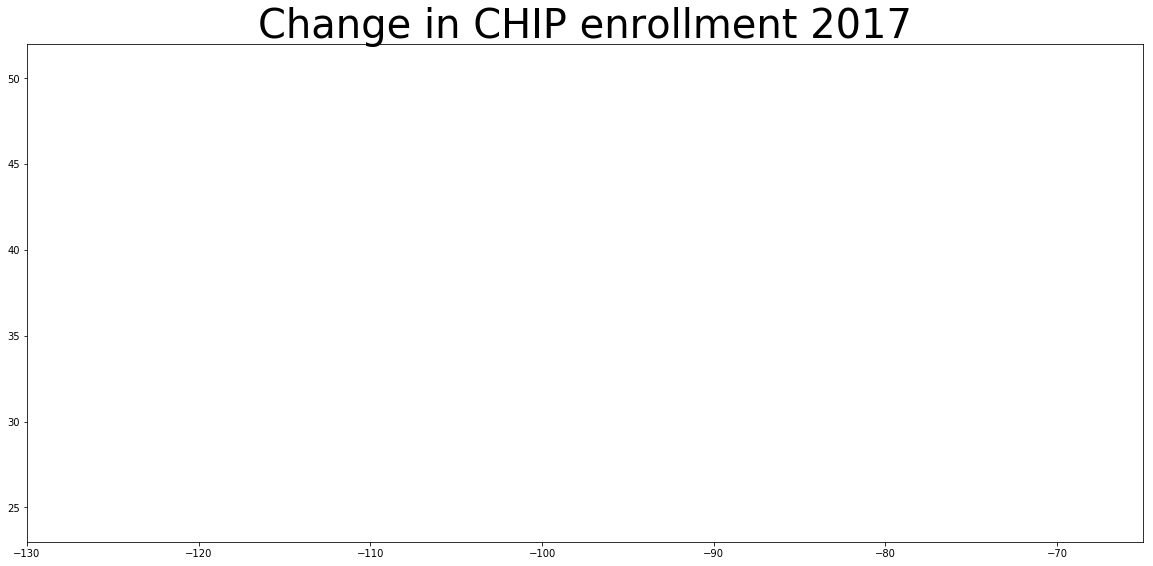

In [46]:
# Plot the map for 2017
f, ax = plt.subplots(figsize=(20, 20))
# minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(-130, -65)
ax.set_ylim(23, 52)
ax.set_title('Change in CHIP enrollment 2017', fontdict={'fontsize': '40', 'fontweight' : '3'})
merged_map_1712.plot(column='chip_change', cmap='RdBu', ax=ax) 
ax.axis('off')
plt.savefig('chip_17.jpg')
plt.show()

In [ ]:
# Plot the map for 2018
f, ax = plt.subplots(figsize=(20, 20))
# minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(-130, -65)
ax.set_ylim(23, 52)
ax.set_title('Change in CHIP enrollment 2018', fontdict={'fontsize': '40', 'fontweight' : '3'})
merged_map_1805.plot(column='chip_change', cmap='RdBu', ax=ax) 
ax.axis('off')
plt.savefig('chip_18.jpg')
plt.show()

In [ ]:
# Plot the map for 2019
f, ax = plt.subplots(figsize=(20, 20))
# minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(-130, -65)
ax.set_ylim(23, 52)
ax.set_title('Change in CHIP enrollment 2019', fontdict={'fontsize': '40', 'fontweight' : '3'})
merged_map_1905_corr.plot(column='chip_change', cmap='RdBu', ax=ax) 
ax.axis('off')
plt.savefig('chip_19.jpg')
plt.show()

## V. Make queries to the dataset

In [47]:
# Create dataframe with variables that will be shown in query
chip_queries=merged_dataframe.copy()
chip_queries=chip_queries[['state', 'month', 'chip_change', 'Median Age', 'Household Income', 'Poverty Rate']]
# chip_queries
# chip_queries.info() 

In [48]:
# Choose the month
print('Enter the month (YYYY-MM): ')
# global month
month = str(input())
# Choose the state 
print('Enter the state name: ')
# global state
state = input()

# Print info
chip_queries.query('state==@state and month==@month' , inplace = True)
chip_queries


Enter the month (YYYY-MM): 
2019-01
Enter the state name: 
Tennessee


,state,month,chip_change,Median Age,Household Income,Poverty Rate
1027,Tennessee,2019-01,-0.353535,38.2,44298.0,17.208144
